In [69]:
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
import math
import statistics
import re

import csv
import networkx as nx

import pickle
import os

# imports
from community import community_louvain
import fa2
import powerlaw
import json
import random
import matplotlib.pyplot as plt

import os
from IPython.display import clear_output 
import gc
import itertools

import nltk
from nltk import FreqDist
from collections import defaultdict
from wordcloud import WordCloud

In [70]:

from networkx.readwrite import json_graph
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [71]:
graph = read_json_file('sp_artists_graph.json')

In [72]:
print("number of nodes:", graph.number_of_nodes())
print("number of edges:", graph.number_of_edges())

number of nodes: 3778
number of edges: 19524


## Density

In [73]:
print(f'Density: {nx.density(graph)}')

Density: 0.0027364647381626244


The density of the graph is quite low which means that the artists is not well connected to each other.

## Degree distribution

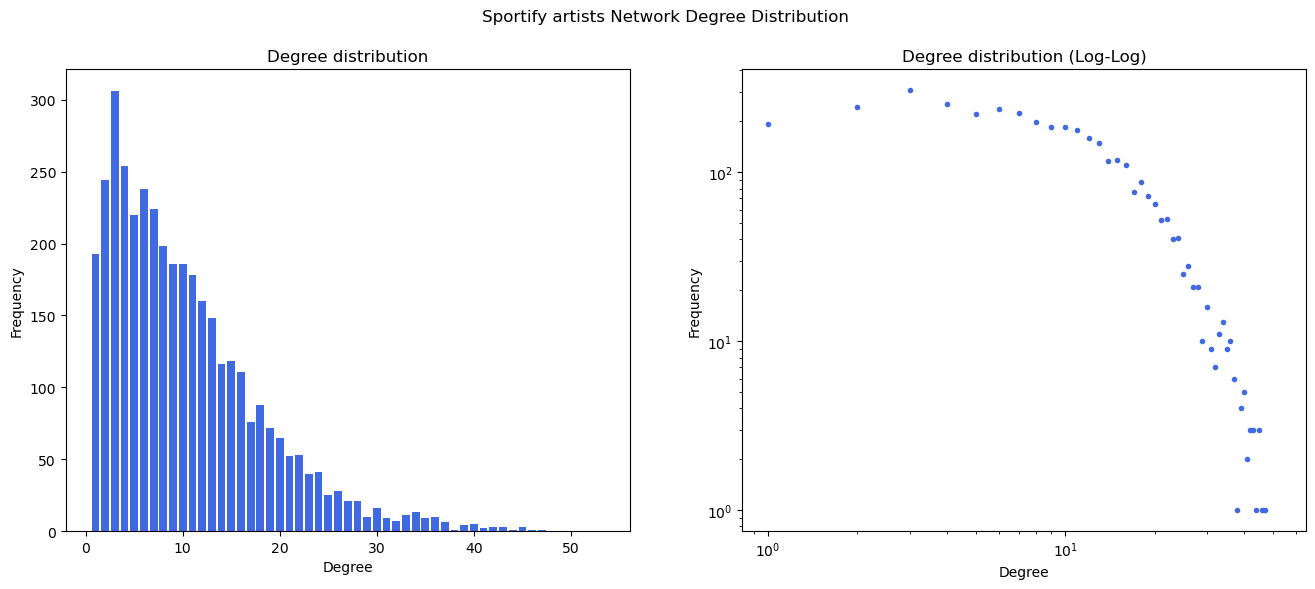

In [74]:
# Plot degree distribution
graph_degree = dict(sorted(dict(graph.degree()).items()))
degree = list(dict(graph.degree()).values())

graph_degree_seq = list(graph_degree.values())
hist, bins = np.histogram(degree, bins=range(min(degree), max(degree))) # return an array with histogram values and the bin edges 

# hist, bins = np.histogram(graph_degree_seq, bins=range(min(graph_degree_seq), max(graph_degree_seq)))


fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Sportify artists Network Degree Distribution")
ax[0].bar(bins[:-1], hist, color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Degree distribution")

ax[1].loglog(bins[:-1], hist,'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Frequency")
ax[1].set_title("Degree distribution (Log-Log)")


plt.show()

In [75]:
print('Average:', round(np.mean(graph_degree_seq),3))
print('Median:', np.median(graph_degree_seq))
print('Mode:', statistics.mode(graph_degree_seq))
print('Max:', max(graph_degree_seq))
print('Min:', min(graph_degree_seq))

Average: 10.336
Median: 9.0
Mode: 3
Max: 55
Min: 1


Since the median value is a bit lower compared to the maximum degree of a network and form visual inspection of the logarithmic plot the scatter points do form sort of a straight line. Therefore can we conclude that if follows a power law distribution.

In [76]:
fit = powerlaw.Fit(graph_degree_seq)
fit.power_law.alpha


Calculating best minimal value for power law fit


5.622522067730465

Since the degree exponent is higher than 3, we determine it to be a small world.

Calculating best minimal value for power law fit
The slope of the incoming degree distribution 5.622522067730465


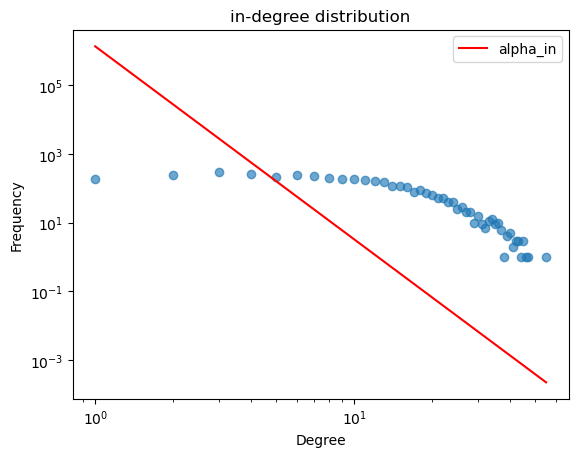

In [77]:
from math import exp
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import powerlaw

degree_sequence = sorted(list(dict(graph.degree()).values()), reverse=True)
alpha_in = powerlaw.Fit(degree_sequence).alpha
print("The slope of the incoming degree distribution", alpha_in)
degree_freq = Counter(degree_sequence)

x = np.log(np.array(list(degree_freq.keys())))
y = np.log(np.array(list(degree_freq.values())))

ymin, ymax = ([0, y.max()])
ymid = (ymin + ymax) / 2
xmin, xmax = ([0, x.max()])
xmid = (xmin + xmax) / 2

y1 = -alpha_in * (xmin - xmid) + ymid
y2 = -alpha_in * (xmax - xmid) + ymid

fig = plt.figure()
ax = plt.gca()
plt.scatter(degree_freq.keys(), degree_freq.values() , alpha=0.65)
ax.plot(np.exp([xmin, xmax]), np.exp([y1, y2]), 'r', label="alpha_in")

plt.title("in-degree distribution")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.loglog()
plt.legend()

## Communities

In [78]:
# compute the best partition
communities = community_louvain.best_partition(graph, random_state=0) 
# we used random_state parameter so that the results can be reproduced
mod = community_louvain.modularity(communities, graph)
print("modularity is", mod)

no_communities = len(Counter(communities.values()))
print("The Louvain algorithm had found", no_communities, "communities")

for community, count in Counter(communities.values()).most_common():
    print("The community", community, "has", count, "nodes")

modularity is 0.8490229257181395
The Louvain algorithm had found 33 communities
The community 14 has 364 nodes
The community 26 has 267 nodes
The community 27 has 266 nodes
The community 23 has 239 nodes
The community 12 has 215 nodes
The community 20 has 198 nodes
The community 15 has 197 nodes
The community 16 has 176 nodes
The community 4 has 157 nodes
The community 2 has 156 nodes
The community 24 has 144 nodes
The community 3 has 129 nodes
The community 1 has 114 nodes
The community 11 has 112 nodes
The community 25 has 104 nodes
The community 0 has 101 nodes
The community 17 has 93 nodes
The community 22 has 92 nodes
The community 31 has 88 nodes
The community 8 has 82 nodes
The community 30 has 66 nodes
The community 6 has 64 nodes
The community 32 has 61 nodes
The community 19 has 47 nodes
The community 7 has 43 nodes
The community 18 has 41 nodes
The community 28 has 39 nodes
The community 9 has 33 nodes
The community 13 has 32 nodes
The community 29 has 24 nodes
The community

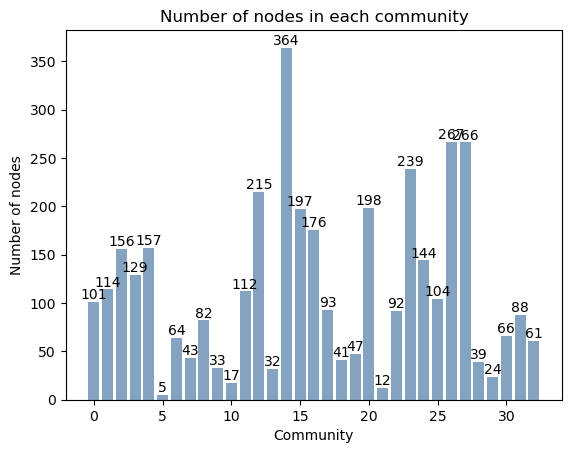

In [79]:
_commnodes = list(Counter(communities.values()).values())
_comm = list(Counter(communities.values()).keys())
fig, ax = plt.subplots()

p = ax.bar(_comm, _commnodes, color=(0.2, 0.4, 0.6, 0.6))

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Number of nodes')
ax.set_xlabel('Community')
ax.set_title('Number of nodes in each community')
ax.bar_label(p)

plt.show()

With a modularity of 0.8 shows that it has a strong community structure

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:18<00:00,  4.01it/s]


BarnesHut Approximation  took  96.15  seconds
Repulsion forces  took  384.51  seconds
Gravitational forces  took  0.32  seconds
Attraction forces  took  2.09  seconds
AdjustSpeedAndApplyForces step  took  6.85  seconds


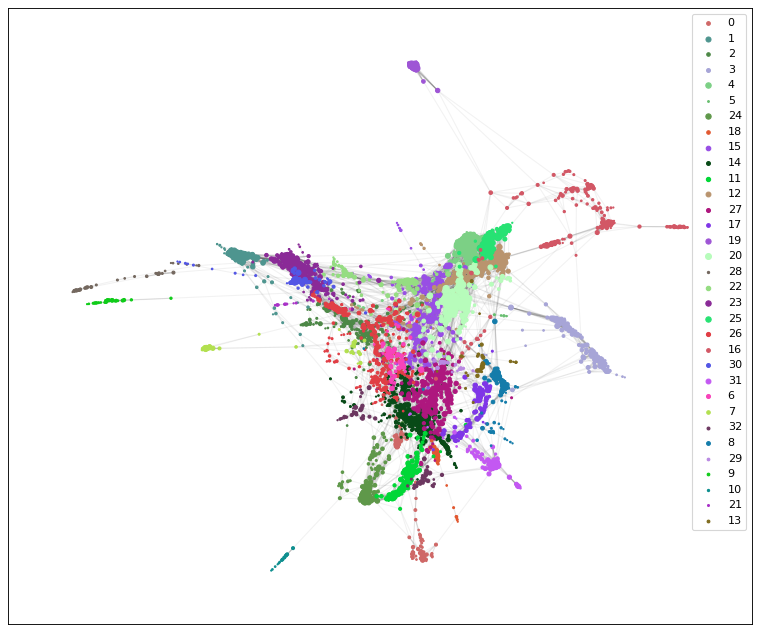

In [80]:
forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.9,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=0.6,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=2000)
        
plt.figure(figsize=(12, 10), dpi=80)
communities_color = {} # keep a dict with colors for each community
nodelist_dc = []

for community in  Counter(communities.values()):
    communities_color[community] = np.array([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])
    nodelist = []
    
    for node in graph:
        if node not in communities:
            nodelist_dc.append(node)
        elif communities[node] == community:
            nodelist.append(node)
    nx.draw_networkx_nodes(graph,
                           pos=positions,
                           nodelist=nodelist,
                           node_size=list(dict(graph.degree(nodelist)).values()),
                           node_color=communities_color[community].reshape(1,-1), label=community)
nx.draw_networkx_edges(graph, pos=positions, alpha=0.05)
plt.legend()


## Clustering Coefficient

In [81]:
cc = nx.clustering(graph)
cc_values = list(cc.values()) 
avg_cc = np.mean(cc_values)
n_cc0 = len(list(filter(lambda n: n == 0, cc_values)))
n_cc1 = len(list(filter(lambda n: n == 1, cc_values)))

print("Average clustering coefficient:", round(avg_cc, 3))
print("Nodes with clustering coefficient 0:", n_cc0)
print("Nodes with clustering coefficient 1:", n_cc1)

Average clustering coefficient: 0.416
Nodes with clustering coefficient 0: 411
Nodes with clustering coefficient 1: 204


Since the clustering is in the middle, we can tell that more of the nodes are closer to 0, than 1. In this way we can conclude that the artists do not necessarily collaborate with others.

In [82]:
# split nodes in communities
comm_split = defaultdict(list)
for key, val in sorted(communities.items()):
    comm_split[val].append(key)
comm_split = dict(sorted(comm_split.items()))

In [83]:
# clustering coefficient for each community:
cc_comm = {}
for key, values in comm_split.items():
    cc_comm[key] = list(nx.clustering(graph.subgraph(values)).values())
cc_comm = dict(sorted(cc_comm.items()))

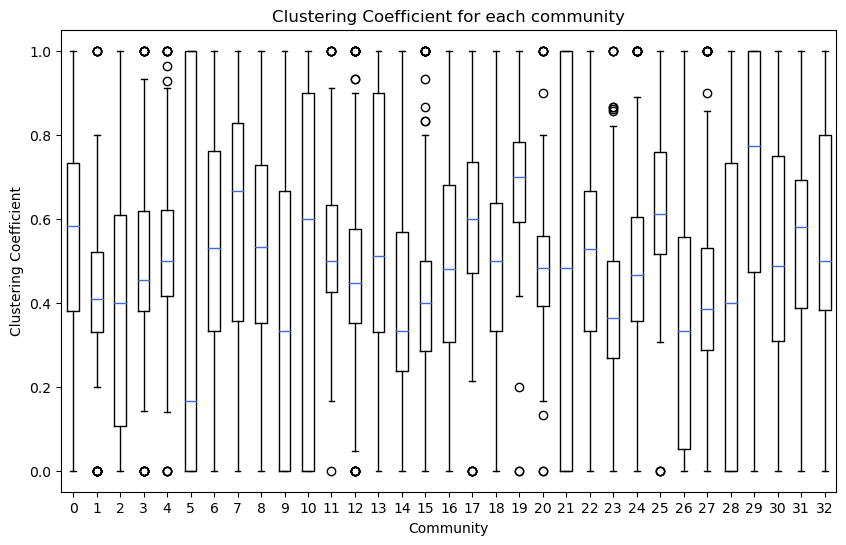

In [84]:
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(cc_comm.values(),
           medianprops=dict(color='royalblue'))

ax.set_xticklabels(cc_comm.keys())
ax.set_ylabel('Clustering Coefficient')
ax.set_xlabel('Community')
ax.set_title('Clustering Coefficient for each community')

plt.show()

We can see that the are some communtites which has higher clustering coefficent than the network. This can mean that the communtites with high clustering has more related artists than others.

# Correlation of Clustering Coefficient vs. Degree

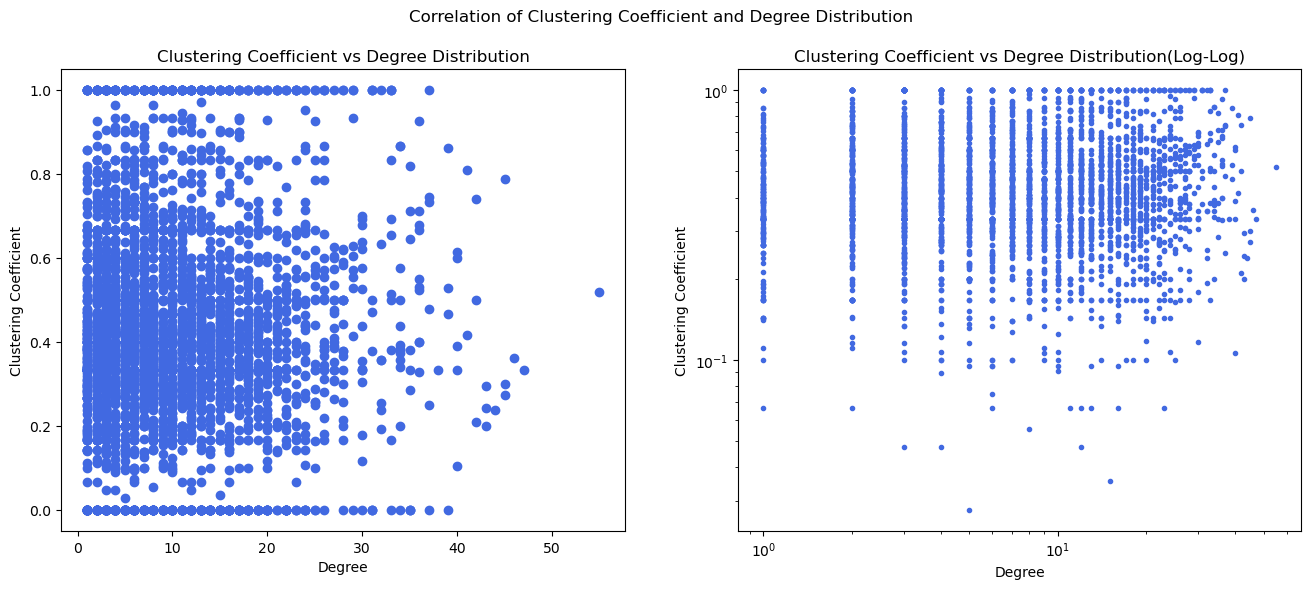

In [85]:
# Plot clustering coefficient vs degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Clustering Coefficient and Degree Distribution")
ax[0].scatter(graph_degree_seq, cc_values, color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Clustering Coefficient")
ax[0].set_title("Clustering Coefficient vs Degree Distribution")

ax[1].loglog(graph_degree_seq, cc_values,'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Clustering Coefficient vs Degree Distribution(Log-Log)")

plt.show()

In [86]:
print("Correlation of Clustering Coefficient and Degree Distribution:", round(np.corrcoef(graph_degree_seq, cc_values)[0,1],2))

Correlation of Clustering Coefficient and Degree Distribution: 0.05


## Centrality

In [87]:
ec = nx.eigenvector_centrality(graph)
ec = dict(sorted(ec.items()))

In [88]:
# eigenvector centrality for each community:
ec_comm = {}
for key, values in comm_split.items():
    ec_comm[key] = list(nx.eigenvector_centrality(graph.subgraph(values), max_iter=1000).values())
ec_comm = dict(sorted(ec_comm.items()))

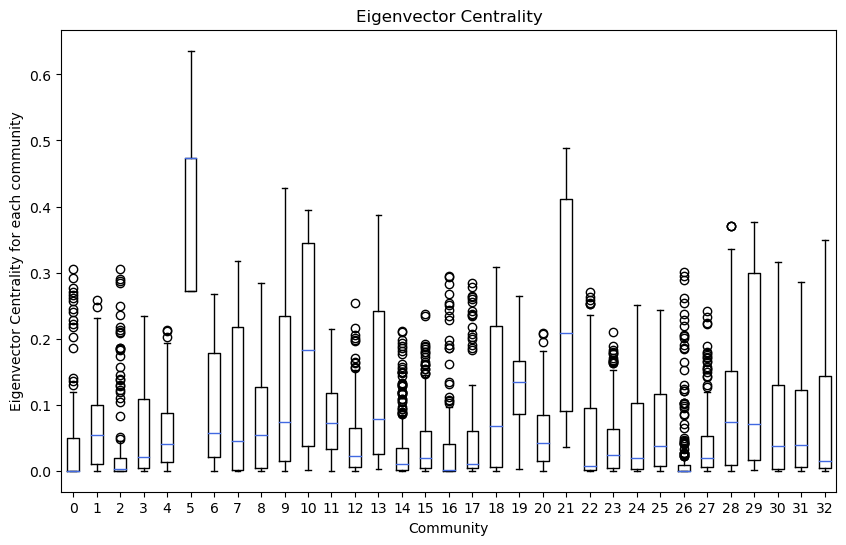

In [89]:
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(ec_comm.values(),medianprops=dict(color='royalblue'))
ax.set_xticklabels(ec_comm.keys())
ax.set_ylabel('Eigenvector Centrality for each community')
ax.set_xlabel('Community')
ax.set_title('Eigenvector Centrality')

plt.show()

# Betweness centrality

In [90]:
g_betweenness = nx.betweenness_centrality(graph)

In [91]:
sorted_dict = {}
sorted_keys = sorted(g_betweenness, key=g_betweenness.get, reverse=True)[:40] # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = g_betweenness[w]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

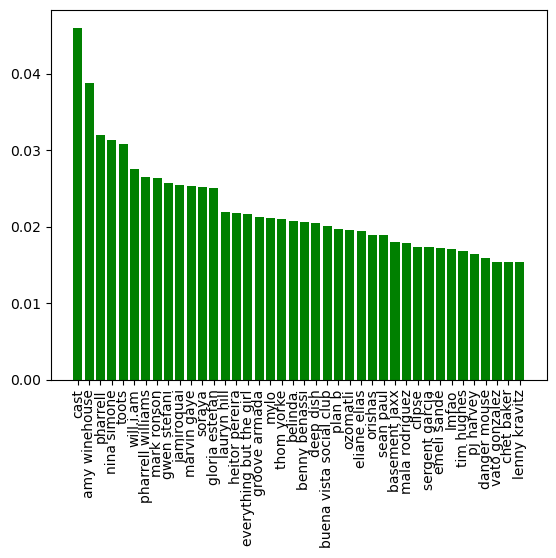

In [92]:
plt.bar(sorted_dict.keys(), sorted_dict.values(), color='g')
plt.xticks(rotation = 90)

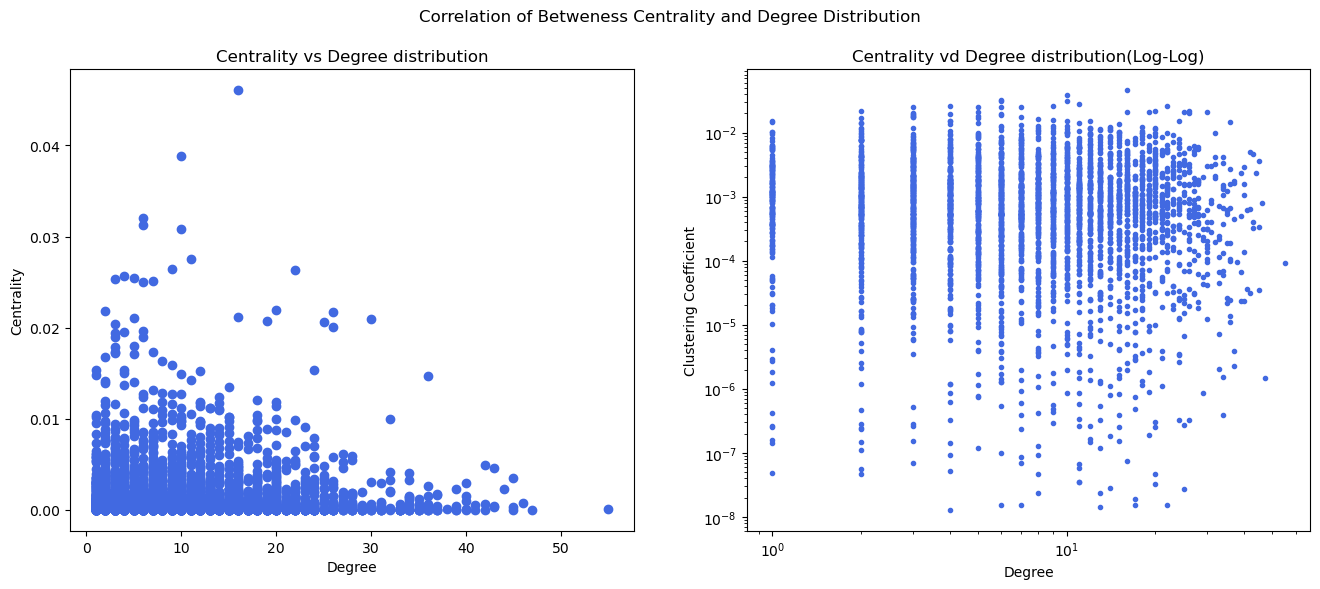

In [93]:
# Plot Centrality and Degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Betweness Centrality and Degree Distribution")
ax[0].scatter(graph_degree_seq, g_betweenness.values(), color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Centrality")
ax[0].set_title("Centrality vs Degree distribution")

ax[1].loglog(graph_degree_seq, list(g_betweenness.values()),'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Centrality vd Degree distribution(Log-Log)")

plt.show()

In [94]:
print("Correlation of Centrality and Degree:", round(np.corrcoef(graph_degree_seq, list(g_betweenness.values()))[0,1],2))

Correlation of Centrality and Degree: -0.02


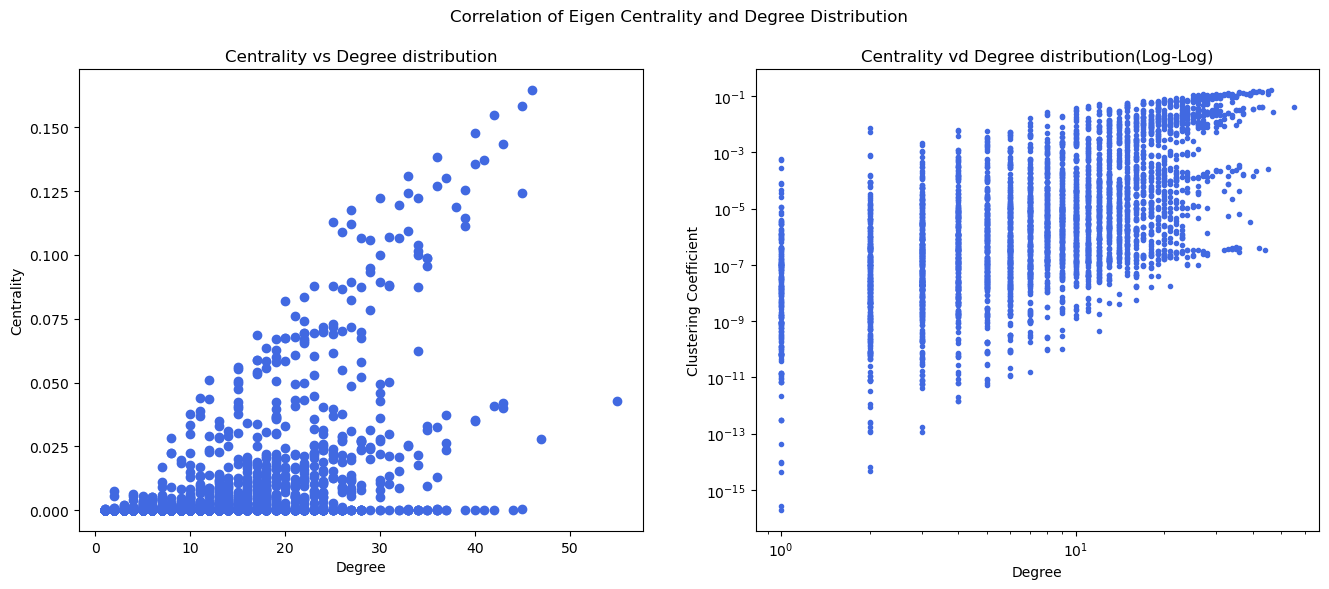

In [95]:
# Plot Centrality and Degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Eigen Centrality and Degree Distribution")
ax[0].scatter(graph_degree_seq, ec.values(), color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Centrality")
ax[0].set_title("Centrality vs Degree distribution")

ax[1].loglog(graph_degree_seq, list(ec.values()),'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Centrality vd Degree distribution(Log-Log)")

plt.show()

In [96]:
print("Correlation of Centrality and Degree:", round(np.corrcoef(graph_degree_seq, list(ec.values()))[0,1],2))

Correlation of Centrality and Degree: 0.52


# Word cloud with artists in community

In [97]:
def computeTF(bag_of_words):
    """
        Get frequency of each word in each document
    """
    return dict([(key, Counter(value)) for key, value in bag_of_words.items()])

def computeIDF(document_words_freq):
    N = len(document_words_freq)
    
    idf_dict = {}
    for document in document_words_freq.values():
        for word, val in document.items():
            if val > 0:
                if word in idf_dict:
                    idf_dict[word] += 1
                else:
                    idf_dict[word] = 1
    
    for word, val in idf_dict.items():
        idf_dict[word] = math.log(N / val)
    return idf_dict

def computeTFIDF(tfs, idfs):
    tfidf = {}
    for word, val in tfs.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [98]:
document_tf = computeTF(comm_split)

In [99]:
# TF_gen = {}
# for key, value in comm_split.items():
#     word_list = list(value)
#     print(word_list[0])
#     break
#     TF_gen[key] = FreqDist(word_list)

In [100]:
word_idf = computeIDF(document_tf)

In [101]:
document_tfidf = dict([(key, computeTFIDF(document_tf[key], word_idf)) for key in comm_split.keys()])

In [102]:
# Plot
def plot_word_cloud(document, title):
    wc = WordCloud(
            background_color="white", 
            max_words=4000, contour_width=3, 
            contour_color='steelblue', 
            collocations=False
        ).generate(document)

    plt.figure(figsize=[8,4])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

In [103]:
spotify_df = pd.read_pickle(r"spotify_dataset_preprocessed.pickle")

In [104]:
spotify_df.artistname = spotify_df.artistname.apply(frozenset)

In [105]:
spotify_df["tracks"] = list(zip(spotify_df['trackname'], spotify_df['artistname']))

In [106]:
spotify_df = spotify_df.drop_duplicates(subset=['user_id','tracks'], keep=False)

In [120]:
artists_freq = Counter([artist for artists in spotify_df.artistname for artist in artists])

In [121]:
artists_freq.most_common()[:5]

[('daft punk', 27517),
 ('coldplay', 26365),
 ('radiohead', 24490),
 ('the rolling stones', 24057),
 ('david bowie', 23074)]

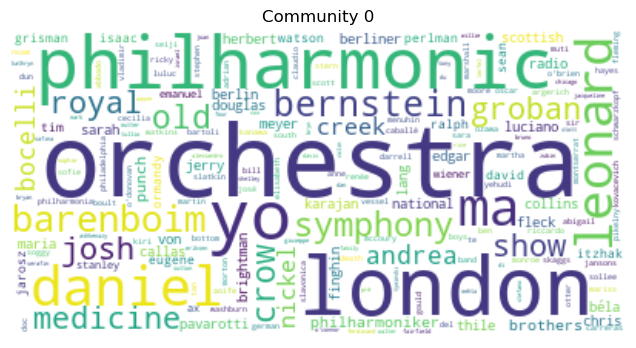

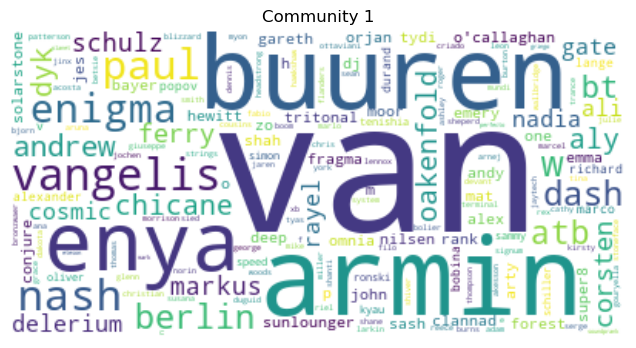

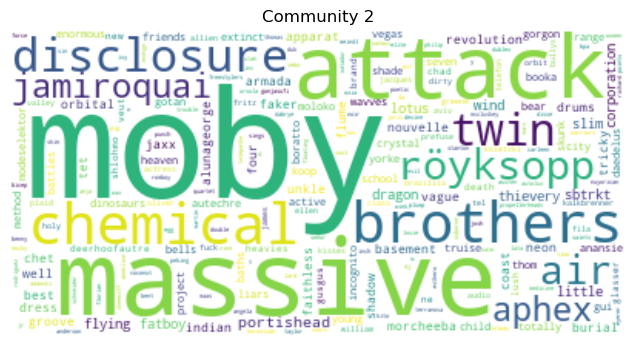

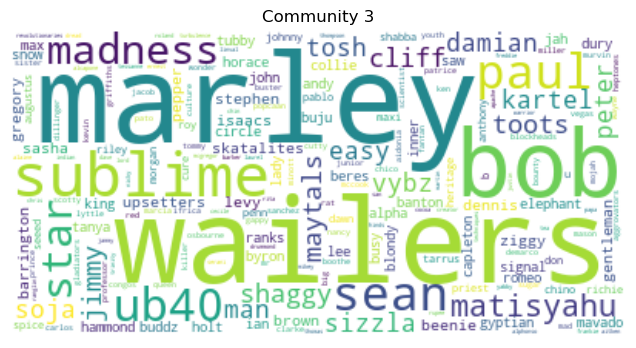

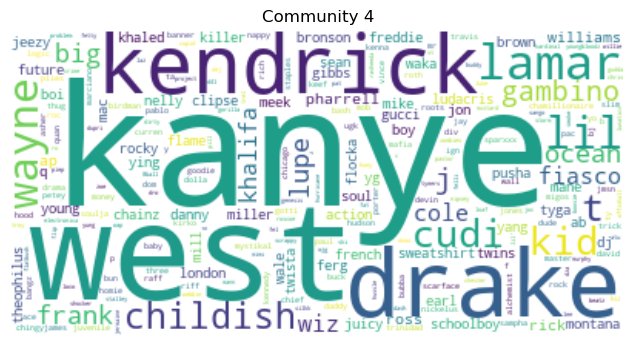

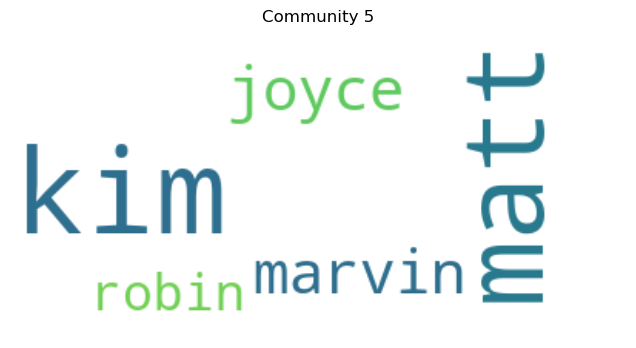

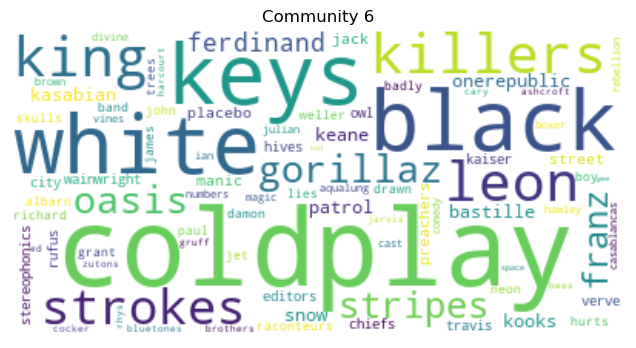

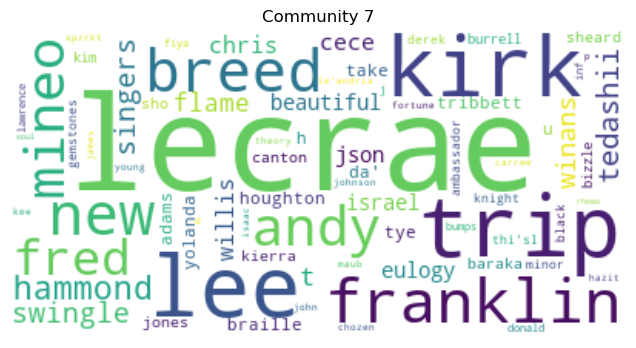

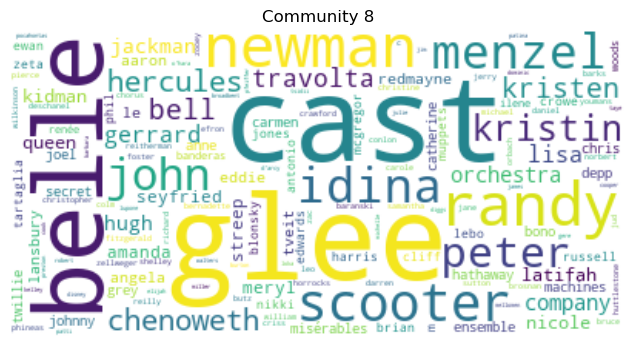

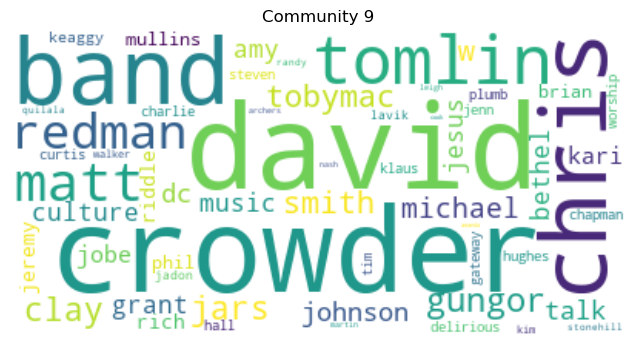

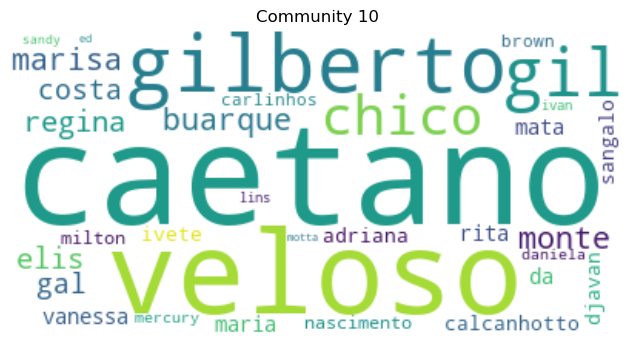

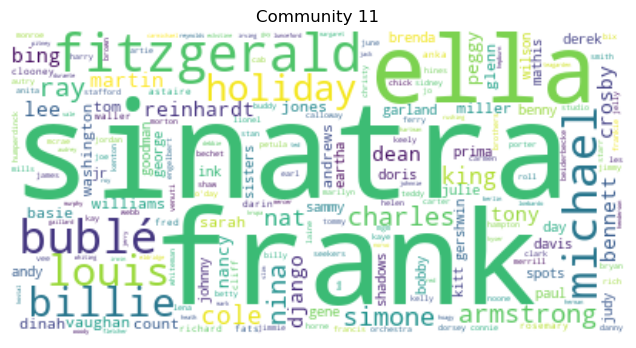

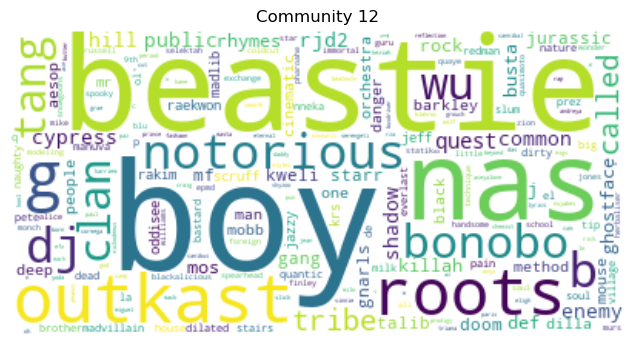

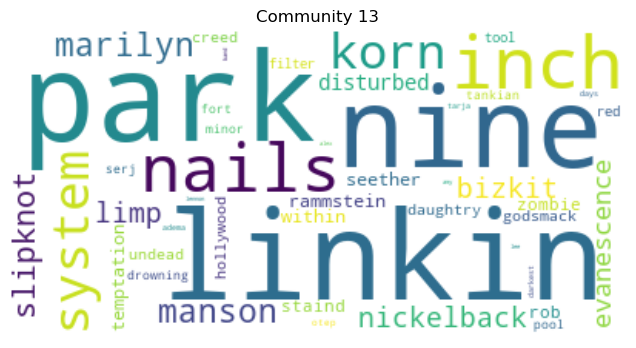

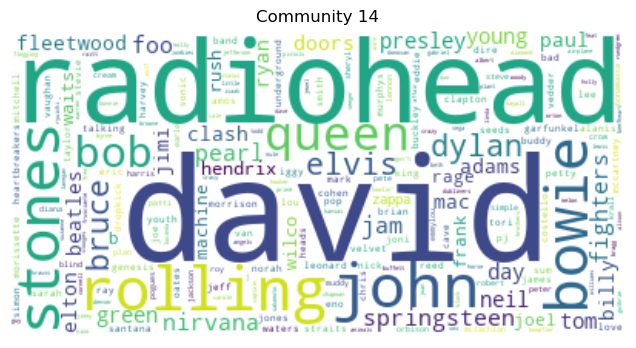

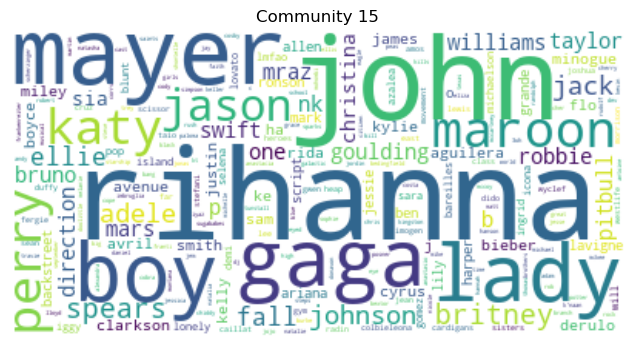

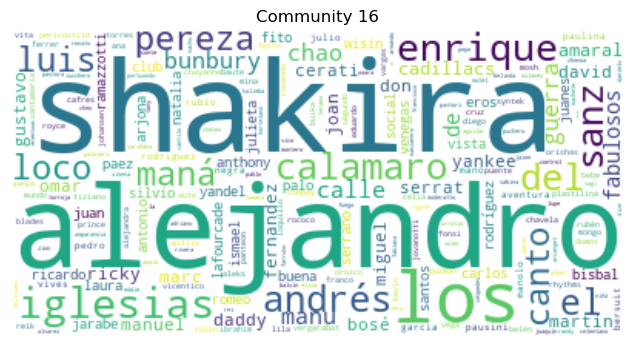

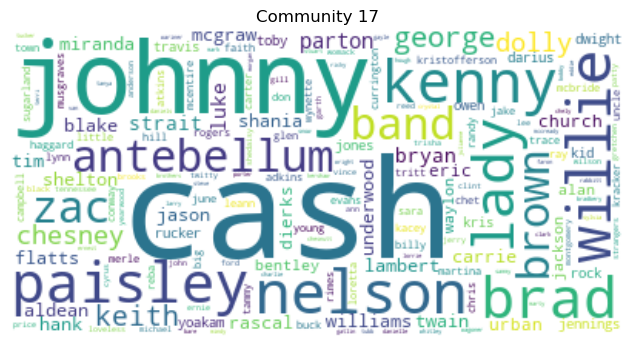

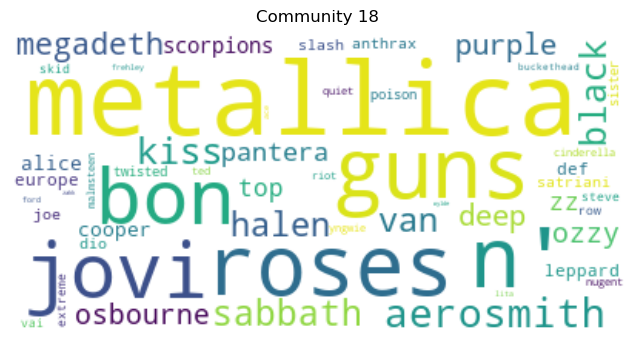

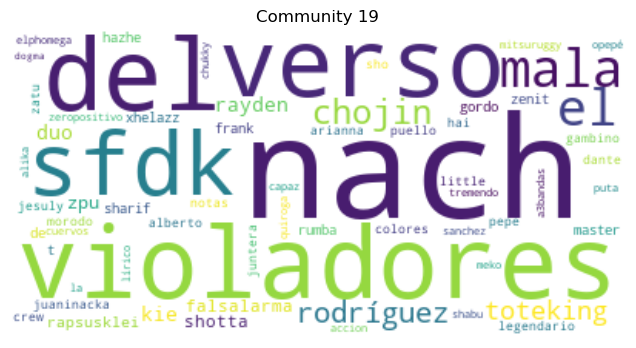

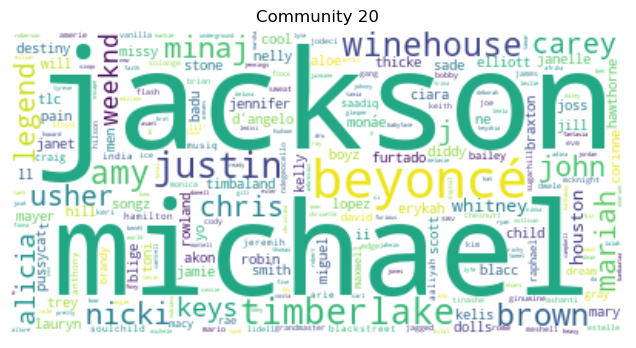

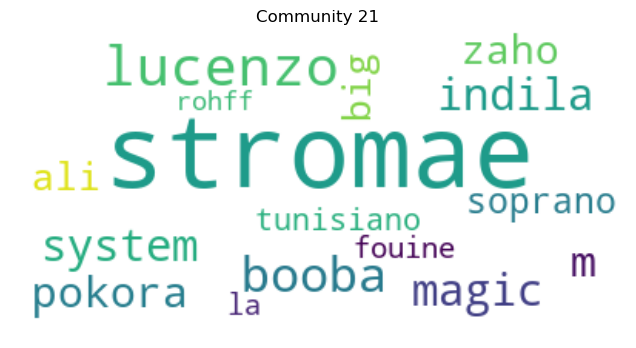

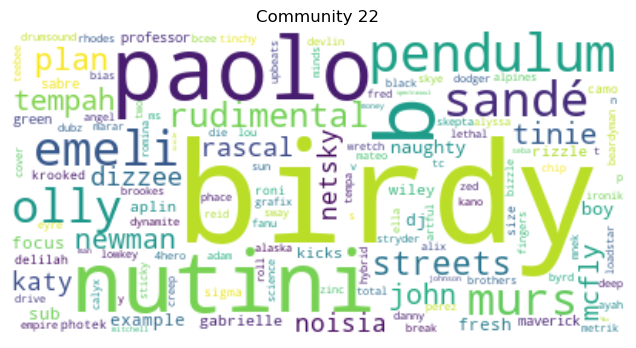

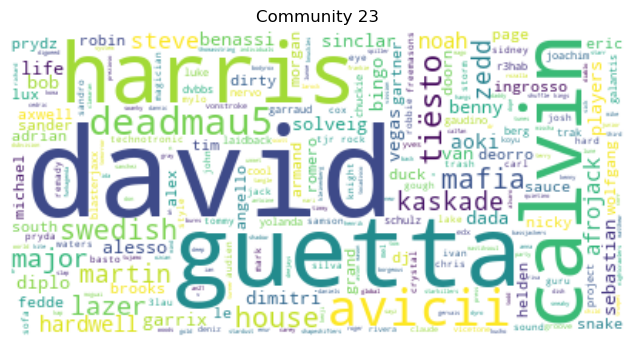

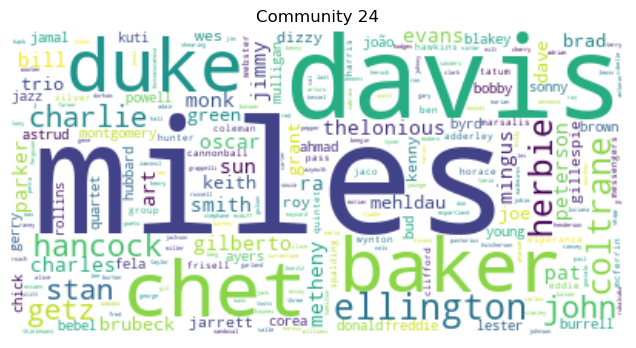

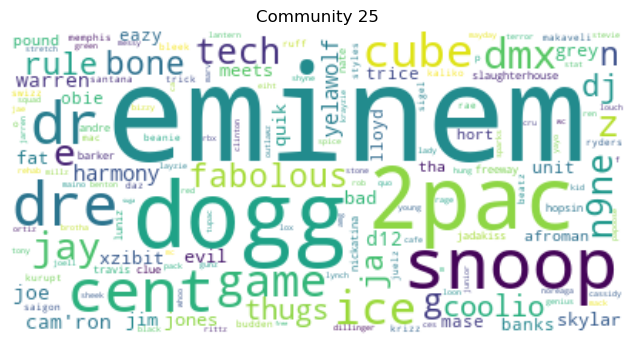

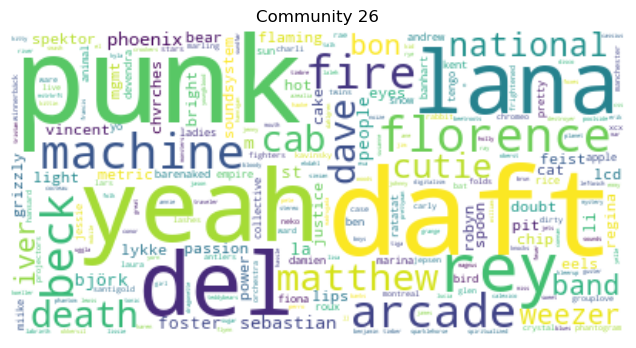

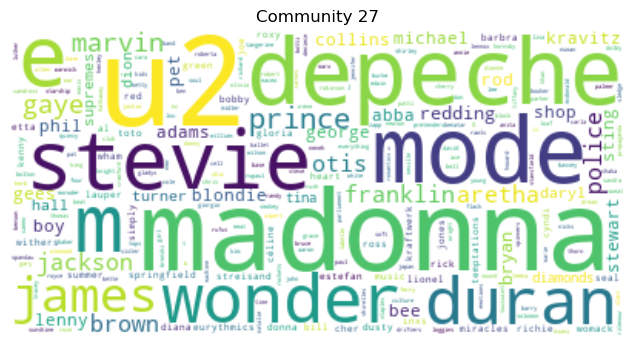

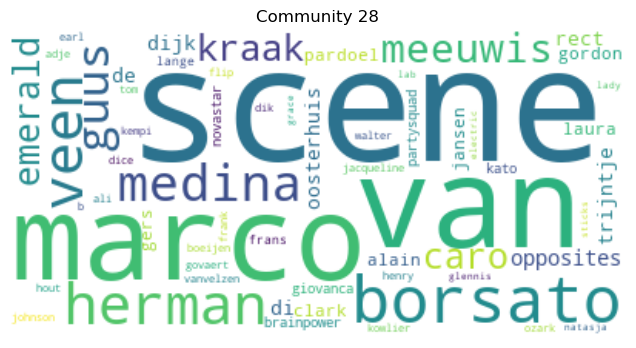

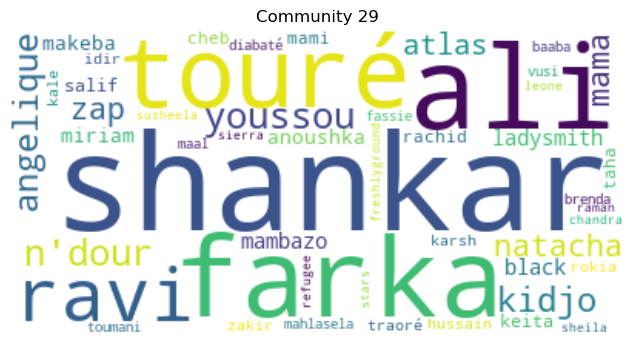

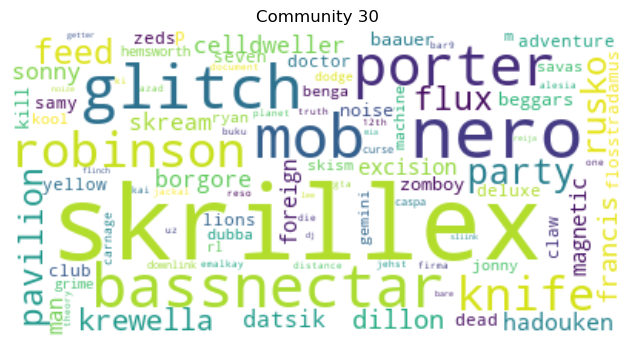

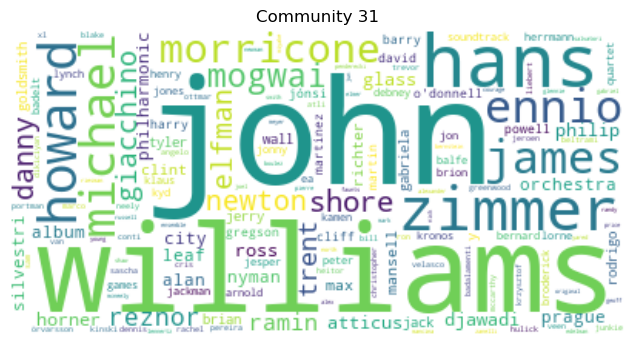

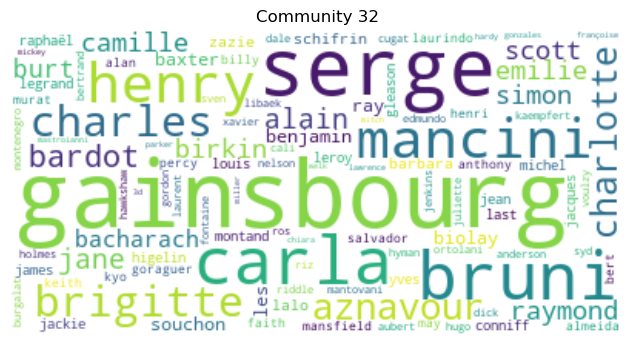

In [124]:
for (key, tfidf_doc) in document_tfidf.items():
    doc_words = " ".join([(w + " ") * artists_freq[w] for w, n in Counter(tfidf_doc).most_common()])
    plot_word_cloud(doc_words, "Community " + str(key))

In [125]:
# for (key, tfidf_doc) in document_tfidf.items():
#     doc_words = " ".join([(w + " ") * int(n) for w, n in Counter(tfidf_doc).most_common()])
#     plot_word_cloud(doc_words, "Community " + str(key))